# CS506 HOS10A – Text Generation Using LSTM
Topic: Automatic Text Generation using LSTM  
Student: Verónica Elze

# === IMPORTS ===

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from keras.models import Sequential  # type: ignore
from keras.layers import Input, Dense, Dropout, LSTM  # type: ignore
from keras.optimizers import RMSprop  # type: ignore
import numpy as np
import random
import sys
from matplotlib import pyplot as plt

# === LOAD DATA ===

In [2]:
filename = "Trading with Mexico.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
print(raw_text[0:1000])

the project gutenberg ebook of trading with mexico
    
this ebook is for the use of anyone anywhere in the united states and
most other parts of the world at no cost and with almost no restrictions
whatsoever. you may copy it, give it away or re-use it under the terms
of the project gutenberg license included with this ebook or online
at www.gutenberg.org. if you are not located in the united states,
you will have to check the laws of the country where you are located
before using this ebook.

title: trading with mexico

author: wallace thompson

release date: february 26, 2025 [ebook #75469]

language: english

original publication: new york: dodd, mead and company, 1921

credits: the online distributed proofreading team at https://www.pgdp.net (this file was produced from images generously made available by the internet archive)


*** start of the project gutenberg ebook trading with mexico ***





                              trading with
                                 mexico



# === CLEAN DATA ===

In [3]:
raw_text = ''.join(c for c in raw_text if not c.isdigit())
chars = sorted(list(set(raw_text)))  # List of every character

# === CHARACTER MAPPING ===

In [4]:
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

# === CHARACTER COUNTS ===

In [5]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length:", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters in the text; corpus length: 387019
Total Vocab:  63


# === CREATE SEQUENCES ===

In [6]:
seq_length = 60  # Length of each input sequence
step = 10  # Instead of moving 1 letter at a time, try skipping a few.
sentences = []  # X values (Sentences)
next_chars = []  # Y values. The character that follows the sentence defined as X

for i in range(0, n_chars - seq_length, step):  # step=1 means each sentence is offset just by a single letter
    sentences.append(raw_text[i: i + seq_length])  # Sequence in
    next_chars.append(raw_text[i + seq_length])  # Sequence out

n_patterns = len(sentences)
print('Number of sequences:', n_patterns)

Number of sequences: 38696


# === VECTORIZATION ===

In [7]:
x = np.zeros((len(sentences), seq_length, n_vocab), dtype=np.bool_)
y = np.zeros((len(sentences), n_vocab), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

print(x.shape)
print(y.shape)
print(y[0:10])

(38696, 60, 63)
(38696, 63)
[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False  True False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False  True False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False Fals

# === MODEL BUILDING ===

In [8]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(seq_length, n_vocab)))
# model.add(Dense(n_vocab, activation='softmax'))
model = Sequential()
model.add(Input(shape=(seq_length, n_vocab)))
model.add(LSTM(128))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 63)             │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,431 (415.75 KB)

 Trainable params: 106,431 (415.75 KB)

 Non-trainable params: 0 (0.00 B)

# === CHECKPOINT CALLBACK ===

In [9]:
from keras.callbacks import ModelCheckpoint
filepath = "saved_weights-{epoch:02d}-{loss:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# === FIT THE MODEL ===

In [10]:
history = model.fit(x, y,
                    batch_size=128,
                    epochs=50,
                    callbacks=callbacks_list)
model.save('my_saved_weights_50epochs.keras')

Epoch 1/50
302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.7829
Epoch 1: loss improved from inf to 2.47737, saving model to saved_weights-01-2.4774.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - loss: 2.7809
Epoch 2/50
302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2.0712
Epoch 2: loss improved from 2.47737 to 2.00996, saving model to saved_weights-02-2.0100.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - loss: 2.0708
Epoch 3/50
302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.8316
Epoch 3: loss improved from 2.00996 to 1.82298, saving model to saved_weights-03-1.8230.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - loss: 1.8315
Epoch 4/50
302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.6955
Epoch 4: loss improved from 1.82298 to 1.68921, saving model to saved_weights-04-1.6892.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - loss: 1.6955
Epoch 5/50
302/303 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.5718
Epoch 5: loss improved from 1.68921 to 1.58389, saving m

# === PLOT TRAINING LOSS ===

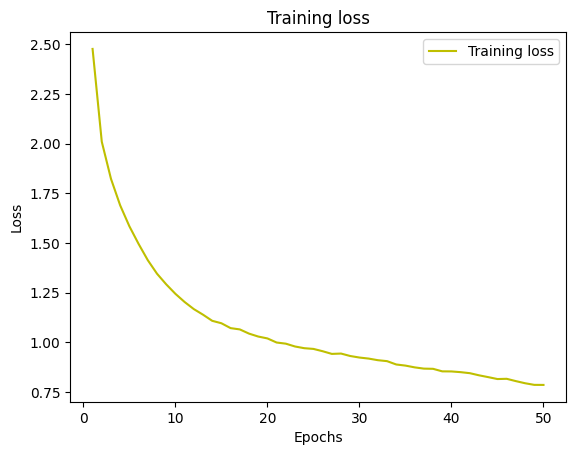

In [11]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# === SAMPLE FUNCTION ===

In [12]:
def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)  # exp of log(x), isn't this same as x??
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# === GENERATE TEXT ===

In [13]:
import glob
latest_model = sorted(glob.glob("saved_weights-50-*.keras"))[-1]
model.load_weights(latest_model)
print(f"Loaded model weights from: {latest_model}")

Loaded model weights from: saved_weights-50-0.7846.keras


### Pick a random sentence from the text as seed.

In [14]:
start_index = random.randint(0, n_chars - seq_length - 1)

### Initiate generated text and keep adding new predictions and print them out

In [15]:
generated = ''
sentence = raw_text[start_index: start_index + seq_length]
generated += sentence
print('----- Seed for our text prediction: "' + sentence + '"')
sys.stdout.write(generated)

----- Seed for our text prediction: "s to issue additional paper currency to cover the
huerta “lo"
s to issue additional paper currency to cover the
huerta “lo

60

### Number of characters including spaces

In [16]:
for i in range(400):
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

ck of the
groentling, full gempore cornilizationage fever i stale of golds of diaz hrone and on mort, and the oil furcheate ites industry and the sprieal of this power
ho cony and under the lands. it, and
structure--aftillinements workigial enough of an are cannilians that it
ister orly
with ittently mexico, and indishers and moreothist, but it is the country, for was only wation parts to buin mel


# REFERENCE
OpenAI. (2025). ChatGPT’s assistance with CS506 HOS10A LSTM text generation example [Large language model]. https://openai.com/chatgpt